# 📊 04_modeling.ipynb

## 🧩 Purpose
In this notebook, we perform a machine learning modeling process to predict **hourly bike rental demand in Seoul** using weather conditions and time-based features. We evaluate multiple models including a baseline and tuned XGBoost.

## 📥 Input Datasets
data/processed/hourly_count_with_weather.csv: Hourly aggregated bike rental data merged with weather information such as temperature, rainfall, humidity, and sunlight.

## 🎯 Goal
- Build and evaluate regression models that predict the **number of hourly bike rentals**.
- Compare performance across models: **Linear Regression, Random Forest, XGBoost**, and **Tuned XGBoost**.
- Analyze **feature importance** using SHAP and visualize **prediction accuracy**.

## ✅ Output
- **Baseline Linear Regression**
    - MAE: `3,230.46`
    - RMSE: `4,228.11`
    - Simple model using only weather features.
    - Underperforms due to inability to capture nonlinear patterns or time effects.

- **Random Forest with One-Hot Encoded Time Features**
    - MAE: `1,027.05`
    - RMSE: `1,697.82`
    - Captures time-of-day effects and nonlinear weather interactions.
    - Feature importance shows `rental_hour` is the most critical factor.

- **XGBoost Regressor**
    - MAE: `1,008.77`
    - RMSE: `1,664.37`
    - Slight improvement over Random Forest.
    - Handles complex relationships well; works better with default parameters.

- **Tuned XGBoost (RandomizedSearchCV)**
    - MAE: `962.43`
    - RMSE: `1,610.30`
    - Best performance among all models.
    - Grid search over `n_estimators`, `max_depth`, `learning_rate`, `subsample`, and more.
    - Further improved by hyperparameter tuning.

- **SHAP Summary Plot**
    - Visualizes how each feature impacts prediction.
    - `rental_hour_18.0`, `daily_rain_mm`, and `is_weekend` are top drivers.
    - Confirms model interprets weather and time signals effectively.

- **Visual Diagnostics**
    - Line plot: Actual vs Predicted values across time.
    - Residual histogram: Mostly centered around 0, indicating no bias.
    - SHAP plot confirms interpretability of the final model.

## ✅ Step 1: Baseline - Linear Regression

### ✅ Result Summary
- **Mean Absolute Error (MAE):** `3,230.46`
- **Root Mean Squared Error (RMSE):** `4,228.11`

### 🔍 Insight
- The Linear Regression model, using only weather-related features (`temperature`, `rainfall`, `wind speed`, `humidity`, `sunlight hours`, `temperature range`, and `rain indicator`), yielded an average prediction error of approximately **3,230 rentals per hour.**
- The RMSE being significantly higher than the MAE suggests that there are **some large outliers** where the model's predictions deviate considerably from the actual values.
- This may indicate that the relationship between the features and the target variable is **not strictly linear**, which limits the performance of a linear model.

### 📌 Limitations and Next Step
- Linear regression assumes a linear relationship between features and the target, which may not capture the **complex, nonlinear patterns** in bike rental behavior.
- In the next step, we will explore **nonlinear models** such as **Random Forests** or **Gradient Boosting** to better model the underlying relationships.
- Additionally, incorporating **time-based features** such as hour of the day, weekday, and weekend indicators may improve predictive performance.

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Visualizing setting
sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [32]:
hourly_df = pd.read_csv('/Users/crunchy__child/seoul-bike-demand/data/processed/hourly_count_with_weather.csv')
hourly_df['datetime'] = pd.to_datetime(hourly_df['datetime'])

In [41]:
hourly_df.drop(columns=['date'], inplace=True)

In [42]:
from sklearn.model_selection import train_test_split

# Set features and target
features = ['avg_temp_C', 'daily_rain_mm', 'avg_wind_mps', 'avg_humidity_pct', 'total_sunlight_hr', 'temp_range', 'rain_binary']
target = 'rental_count'

X = hourly_df[features]
y = hourly_df[target]

# Split train and test sets(train set 8 : 2 test set)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

# Define model and train
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predicted value using test set
y_pred = lr.predict(X_test)

# Evaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 3230.46
RMSE: 4228.11


## ✅ Step 2: Imporved Modeling1 - Random Forest Regressor

### ✅ Result Summary
- **Mean Absolute Error (MAE):** `1,027.05`
- **Root Mean Squared Error (RMSE):** `1,697.82`

### 🔍 Insight
- After applying **one-hot encoding** to categorical time features (`rental_hour`, `rental_weekday`, `is_weekend`), the Random Forest model significantly improved performance compared to the baseline linear regression.
- The MAE decreased from `3,230.46` to `1,027.05`, and RMSE dropped from `4,228.11` to `1,697.82`, indicating much more accurate predictions.
- This suggests that **nonlinear relationships and interactions** between time and weather variables are crucial in predicting hourly bike rental demand.
- Random Forest is capable of capturing these complex patterns, especially when using categorical time features.

### 📌 Limitations and Next Step
- While performance improved, the model could still be enhanced by:
    - **Tuning hyperparameters** (e.g., depth, number of trees, minimum samples per leaf).
    - **Incorporating external factors** such as holidays, events, or traffic data.
- Next, we may consider using **Gradient Boosting (e.g., XGBoost or LightGBM)** for further improvement.

In [44]:
# One-Hot Encoding
categorical_cols = ['rental_hour', 'rental_weekday', 'is_weekend']
hourly_encoded = pd.get_dummies(hourly_df, columns=categorical_cols, drop_first=True) # Drop first category to avoid multicollinearity
hourly_encoded.columns

Index(['datetime', 'rental_count', 'avg_temp_C', 'daily_rain_mm',
       'avg_wind_mps', 'avg_humidity_pct', 'total_sunlight_hr', 'temp_range',
       'rain_binary', 'rental_hour_1.0', 'rental_hour_2.0', 'rental_hour_3.0',
       'rental_hour_4.0', 'rental_hour_5.0', 'rental_hour_6.0',
       'rental_hour_7.0', 'rental_hour_8.0', 'rental_hour_9.0',
       'rental_hour_10.0', 'rental_hour_11.0', 'rental_hour_12.0',
       'rental_hour_13.0', 'rental_hour_14.0', 'rental_hour_15.0',
       'rental_hour_16.0', 'rental_hour_17.0', 'rental_hour_18.0',
       'rental_hour_19.0', 'rental_hour_20.0', 'rental_hour_21.0',
       'rental_hour_22.0', 'rental_hour_23.0', 'rental_weekday_Monday',
       'rental_weekday_Saturday', 'rental_weekday_Sunday',
       'rental_weekday_Thursday', 'rental_weekday_Tuesday',
       'rental_weekday_Wednesday', 'is_weekend_True'],
      dtype='object')

In [45]:
from sklearn.model_selection import train_test_split

# Set features and target
X = hourly_encoded.drop(['rental_count', 'datetime'], axis=1)
y = hourly_encoded['rental_count']

# Split train and test sets(train set 8 : 2 test set)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
from sklearn.ensemble import RandomForestRegressor

# Define model and train
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [47]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Predicted value using test set
y_pred = model.predict(X_test)

# Evaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 1027.05
RMSE: 1697.82


### 📊 Feature Importance
The chart below shows the top features contributing to the model’s predictions:
- The **hour of rental** (especially around 18:00) is by far the most important predictor of demand.
- **Weekend indicator** and **late afternoon/evening hours** (17–20) follow as strong drivers of rental behavior.
- Some weather-related features like **humidity**, **rainfall**, and **sunlight hours** also play meaningful roles.
- **Weekday names** and **rain_binary** were relatively unimportant, suggesting people rent bikes regardless of rain or specific day of the week.

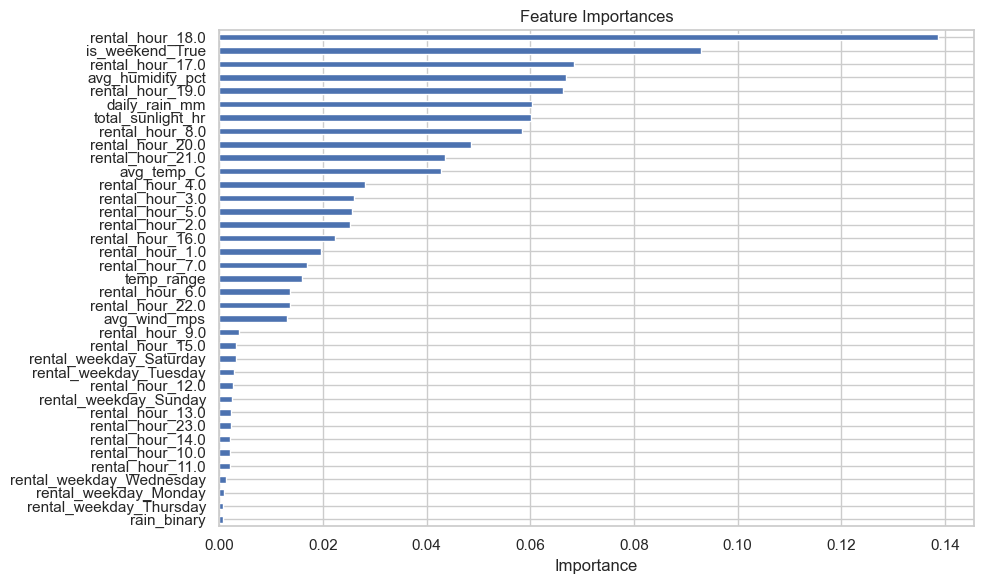

In [48]:
# Visualize feature importances
feature_importance = pd.Series(model.feature_importances_, index=X.columns)
feature_importance = feature_importance.sort_values(ascending=True)

plt.figure(figsize=(10, 6))
feature_importance.plot(kind='barh')
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

## ✅ Step 3: Imporved Modeling2 - XGBoost

### ✅ Result Summary
- **Mean Absolute Error (MAE):** `1,008.77`
- **Root Mean Squared Error (RMSE):** `1,664.37`

### 🔍 Insight
- The XGBoost model **slightly outperformed** the Random Forest model:
    - MAE improved from 1,027.05 → 1,008.77
    - RMSE improved from 1,697.82 → 1,664.37
- While the gain is **modest**, it indicates XGBoost's superior ability to handle subtle nonlinear patterns and feature interactions.
- XGBoost also offers more options for **regularization** and **fine-tuning**, which can be leveraged in further optimization steps.

### 📌 Limitations and Next Step
- Although XGBoost provides better accuracy, the current model uses **default hyperparameters**.
- Further performance gain may be possible by:
    - **Hyperparameter tuning** using grid search or randomized search
    - **Cross-validation** to ensure stability
    - Investigating **feature interactions**, e.g., combinations of time and weather
- Visualization of XGBoost’s feature importance can provide additional insight (e.g., via .feature_importances_ or SHAP values).

In [67]:
from xgboost import XGBRegressor

# Define model and train
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Predicted value using test set
y_pred_xgb = xgb_model.predict(X_test)

# Evaluation
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = root_mean_squared_error(y_test, y_pred_xgb)

print(f"XGBoost MAE: {mae_xgb:.2f}")
print(f"XGBoost RMSE: {rmse_xgb:.2f}")

XGBoost MAE: 1008.77
XGBoost RMSE: 1664.37


### 📊 Feature Importance (Frequency-Based)
- This plot visualizes the top 10 most frequently used features in the XGBoost model based on **split count** (`importance_type='weight'`).
- The higher the bar, the more often the feature was used in decision tree splits during model training.
- **Weather-related features** such as `avg_temp_C`, `daily_rain_mm`, and `avg_humidity_pct` were split on most frequently, indicating they are highly referenced by the model.
- ⚙️ You can generate alternative feature importance plots by changing the `importance_type` parameter in `plot_importance()`:
    - `'gain'`: Average improvement in accuracy from splits involving the feature.
    - `'cover'`: Average number of samples affected by those splits.
- This helps you view importance from **multiple perspectives** — frequency, accuracy impact, and data coverage.

<Figure size 1000x600 with 0 Axes>

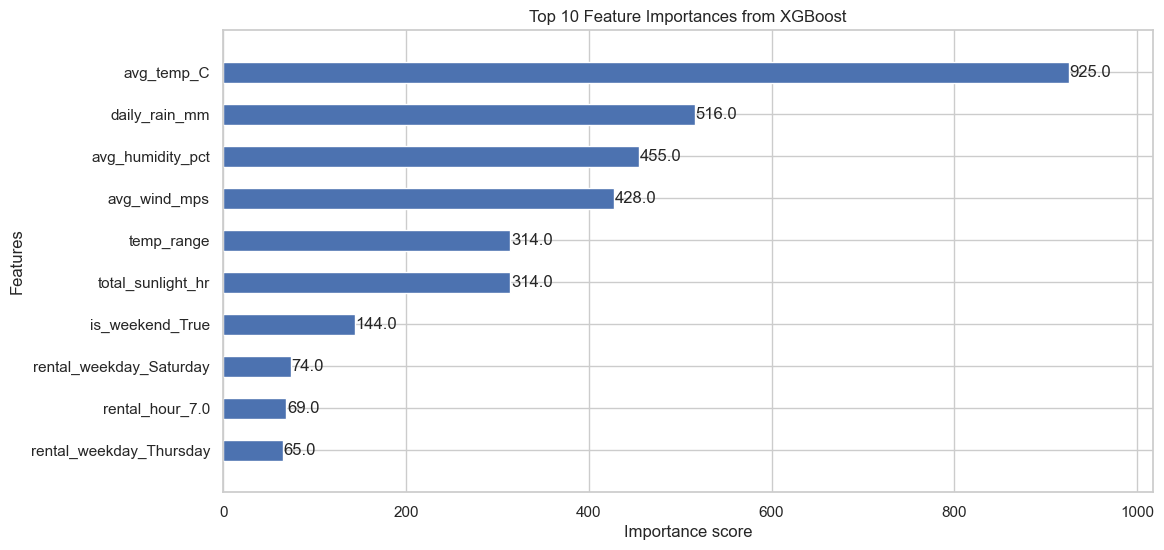

In [76]:
# Visualize feature importances (Frequency-based)
from xgboost import plot_importance

plt.figure(figsize=(10, 6))
plot_importance(xgb_model, max_num_features=10, height=0.5, importance_type='weight')
plt.title('Top 10 Feature Importances from XGBoost')
plt.show()

### 📊 Prediction vs Actual Visualization
- This chart compares actual and predicted rental counts for the first 100 test samples.
- The XGBoost model generally **follows the overall trend**, showing reasonable prediction accuracy.
- Some **spikes and dips are under- or over-estimated**, suggesting potential improvement areas with added features (e.g., lag values, holidays).
- Overall, the model captures **hourly demand patterns** fairly well.

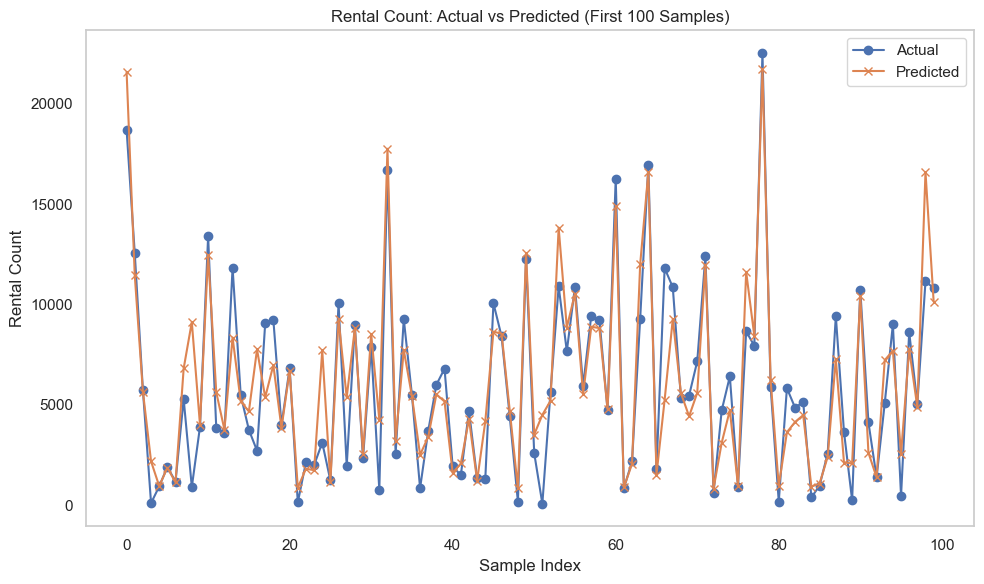

In [ ]:
# Prediction vs Actual Visualization
plt.figure(figsize=(10, 6))
plt.plot(y_test.values[:100], label='Actual', marker='o')
plt.plot(y_pred[:100], label='Predicted', marker='x')
plt.title('Rental Count: Actual vs Predicted (First 100 Samples)')
plt.xlabel('Sample Index')
plt.ylabel('Rental Count')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

### 📊 Residual Distribution
- This plot shows the distribution of residuals (Actual - Predicted) from the XGBoost model.
- The distribution is **approximately centered around 0**, indicating that the model is not systematically over- or under-predicting.
- The shape is slightly **skewed and has heavy tails**, suggesting that while most predictions are close to actual values, **some large errors** (outliers) still exist.
- This insight supports further work on **handling extreme demand spikes**, possibly with outlier handling or additional features.

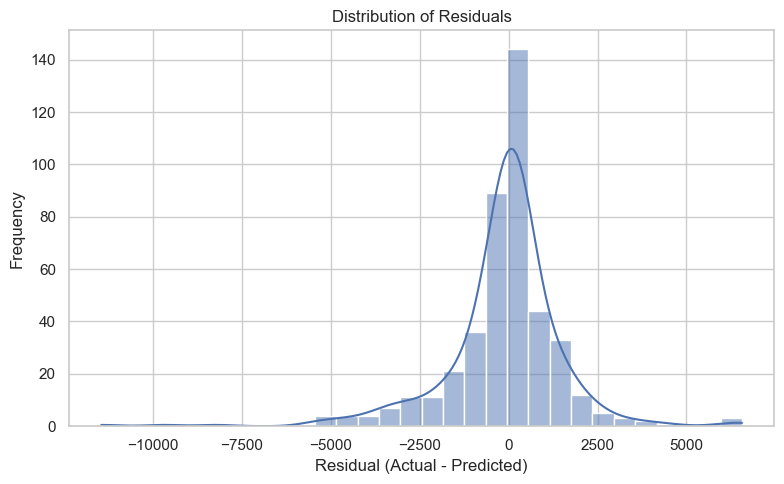

In [53]:
# Calculate residuals
residuals = y_test - y_pred

# Histogram + KDE plot
plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=30, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residual (Actual - Predicted)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

## ✅ Step 4: Tuned XGBoost (RandomizedSearchCV)

### ✅ Result Summary
- **Mean Absolute Error (MAE):** `962.43`
- **Root Mean Squared Error (RMSE):** `1610.30`

### 🔧 Tuning Setup
- Tuning performed using `RandomizedSearchCV` with 3-fold cross-validation.
- Search space included: 
    ```python
        param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'gamma': [0, 0.1, 0.3]
        }
- Scoring metric: **negative mean absolute error**
- Number of iterations: `20`


### 🔍 Insight
- Tuning the XGBoost hyperparameters led to further improvements:
    - MAE dropped from **1,008.77** → **962.43**
    - RMSE dropped from **1,664.37** → **1,610.30**
- This confirms that **default parameters are not optimal**, and even a relatively small search improves performance.
- The best model balances tree complexity, learning rate, and regularization for this dataset.

### 📌 Limitations and Next Step
- Explore **SHAP values** to interpret feature-level impacts from the tuned model.

In [57]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3]
}

In [61]:
xgb = XGBRegressor(random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=20,  # Number of iteration (take long time if it's too big)
    cv=3,
    scoring='neg_mean_absolute_error',
    verbose=1,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraint...
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None, ...),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0, 0.1, 0.3],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [3, 5, 7],
                                        'n_estimators': [100, 200, 300],
                                        'subsample': [0.6, 0.8, 1.0]},
                   scoring='neg_mean_absolute_error', verbose=1)

In [62]:
best_model = random_search.best_estimator_

y_pred = best_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print("🔧 Tuned XGBoost MAE:", round(mae, 2))
print("🔧 Tuned XGBoost RMSE:", round(rmse, 2))

🔧 Tuned XGBoost MAE: 962.43
🔧 Tuned XGBoost RMSE: 1610.3


In [77]:
mean_rental = hourly_encoded['rental_count'].mean()  # Actual average rental count

# Calculate rate
mae_rate = mae / mean_rental
rmse_rate = rmse / mean_rental

# Convert to percentile
print(f"MAE rate: {mae_rate:.4f} ({mae_rate*100:.2f}%)")
print(f"RMSE rate: {rmse_rate:.4f} ({rmse_rate*100:.2f}%)")

MAE rate: 0.1613 (16.13%)
RMSE rate: 0.2699 (26.99%)


### 📊Hourly Bike Rentals: Actual vs Predicted
- This plot compares the **actual** and **predicted** hourly bike rental counts across the entire test set, sorted by time.
- The model successfully follows the **general trends**, including spikes during peak hours.
- However, some extreme values are still under- or over-estimated, especially during high-demand hours.
- The visualization confirms that the tuned XGBoost model is capable of capturing **temporal rental patterns**, though **further refinement** may help improve peak-hour accuracy.

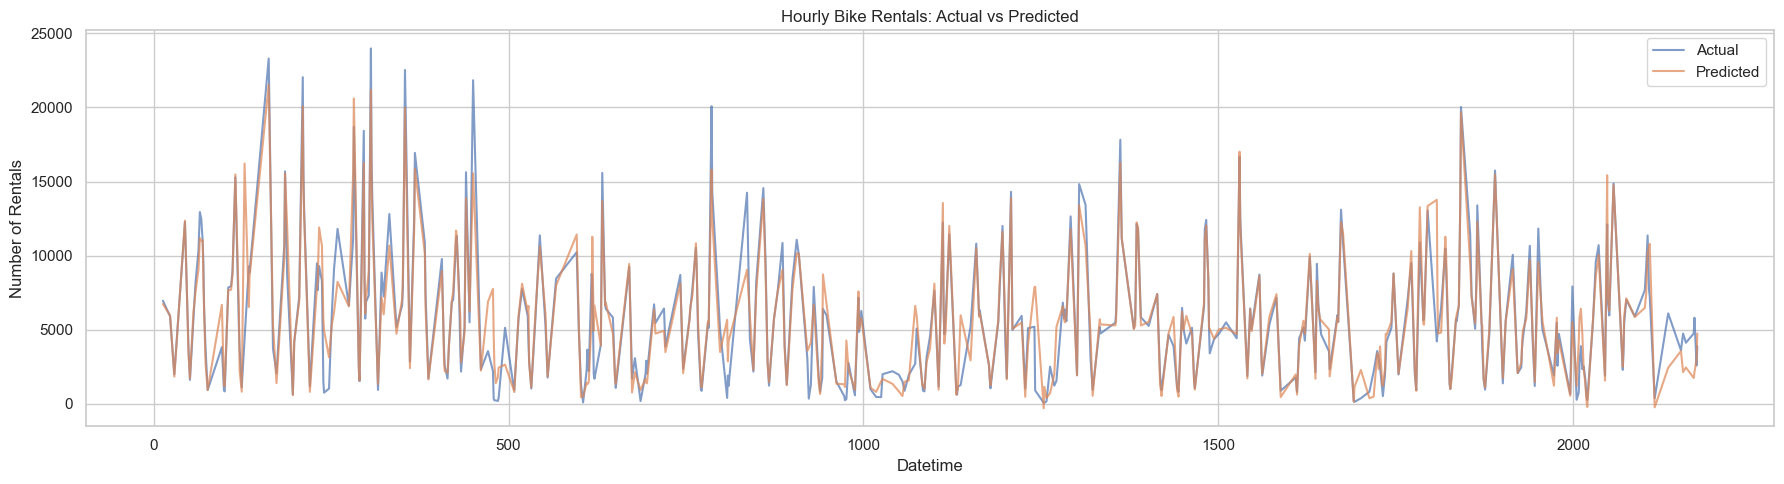

In [ ]:
# Organize actual and predicted value in dataframe
results_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred
}, index=y_test.index)

# Sort by time
results_df = results_df.sort_index()

# Visualize
plt.figure(figsize=(18, 5))
plt.plot(results_df.index, results_df['Actual'], label='Actual', alpha=0.7)
plt.plot(results_df.index, results_df['Predicted'], label='Predicted', alpha=0.7)
plt.title('Hourly Bike Rentals: Actual vs Predicted')
plt.xlabel('Datetime')
plt.ylabel('Number of Rentals')
plt.legend()
plt.tight_layout()
plt.show()

### 🧠 SHAP Summary Plot (Feature Impact)
- This plot shows the **magnitude and direction** of each feature’s impact on the model’s predictions using SHAP (SHapley Additive exPlanations).
- Each dot represents a single row (sample) from the training set.
- The **x-axis** indicates the SHAP value, i.e., the feature’s impact on increasing or decreasing the prediction.
- **Color** represents the feature’s value: red = high, blue = low.

### 🔍 Key Insights
- `daily_rain_mm`: Higher rain levels generally decreased rental count predictions (most red dots on the left).
- `rental_hour_18.0` **and** `rental_hour_19.0`: Strong positive effect — high values of these time slots increase prediction.
- `is_weekend_True`: Being the weekend decreases predicted rentals.
- **Weather-related features** like `avg_temp_C` and `avg_humidity_pct` also significantly influence model predictions.
- Some features (e.g., `temp_range`) have minimal SHAP impact, indicating limited influence.

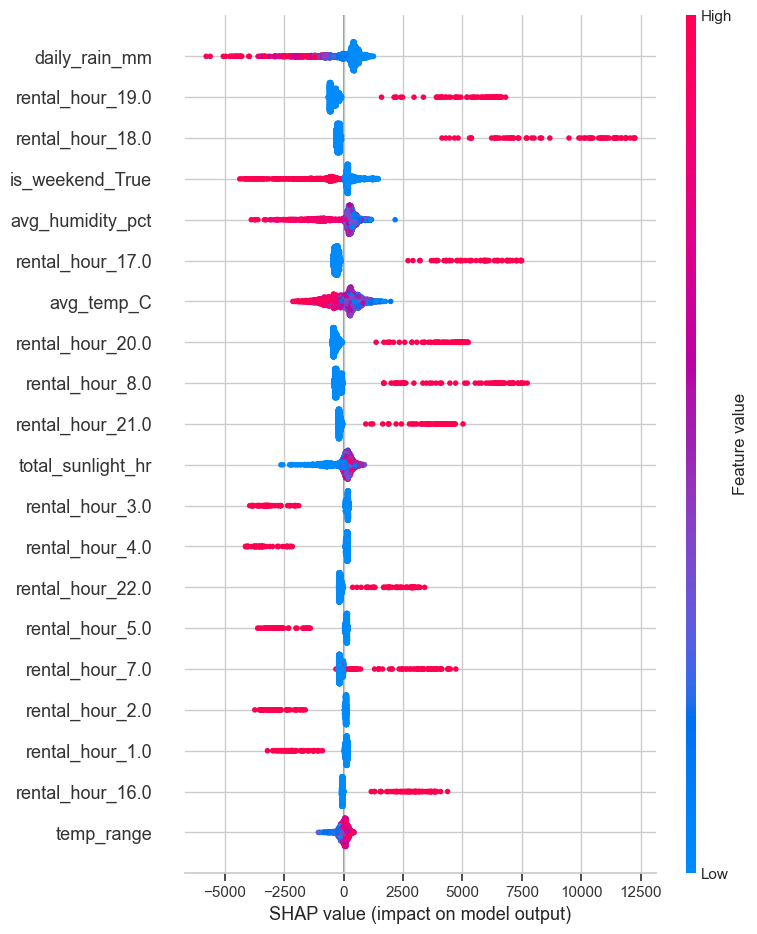

In [ ]:
import shap

# Convert bool → int
bool_cols = X_train.select_dtypes(include='bool').columns
X_train[bool_cols] = X_train[bool_cols].astype(int)

# Create explainer based on training data
explainer = shap.Explainer(xgb_model, X_train)

# Calculate SHAP
shap_values = explainer(X_train)

# SHAP summary plot
shap.summary_plot(shap_values, X_train)